# Analysis of Hospital Readmission rates based on Haemoglobin measurements

## Data Load and Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
diabetes_df = pd.read_csv('diabetic_data.csv')
print("All the columns of the dataset\n", diabetes_df.columns)
diabetes_df.head()

All the columns of the dataset
 Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

### Data preprocessing

1. The following columns are dropped- encounter_id, patient_nbr, weight, age, payer_code, medical_specialty, race and diag-1,2,3

2. Replace the values of the target feature-readmitted with numerical values.

In [5]:
# including age column
diabetes_df = diabetes_df.drop(['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty', 'diag_1',
                                'diag_2', 'diag_3'], axis=1)
diabetes_df["readmitted"] = diabetes_df.apply(lambda row: 0 if row.readmitted=='NO' else 1 if row.readmitted=='>30' else 2 if row.readmitted=='<30' else '', axis=1)
print(f"Shape of dataset: {diabetes_df.shape}")

Shape of dataset: (101766, 42)


In [6]:
diabetes_df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0


In [7]:
diabetes_df.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607,0.572480
std,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600,0.684068
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,1.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000,2.000000


In [8]:
diabetes_df.groupby(by = "readmitted").count()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
readmitted,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864,54864
1,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545,35545
2,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357,11357


### Correlation between features and the target feature (readmitted).

From the Pearson correlation calculated for the numerical features, most of the numerical features have weak correlation with target.

In [9]:
corr_matrix = diabetes_df.corr()
corr_matrix["readmitted"].sort_values(ascending=False)

readmitted                  1.000000
number_inpatient            0.234283
number_diagnoses            0.104820
number_emergency            0.103024
number_outpatient           0.068552
time_in_hospital            0.057718
num_medications             0.051772
num_lab_procedures          0.037976
admission_source_id         0.031816
discharge_disposition_id    0.012450
admission_type_id          -0.008950
num_procedures             -0.038235
Name: readmitted, dtype: float64

### Univariate distribution of each of the continuous variable.

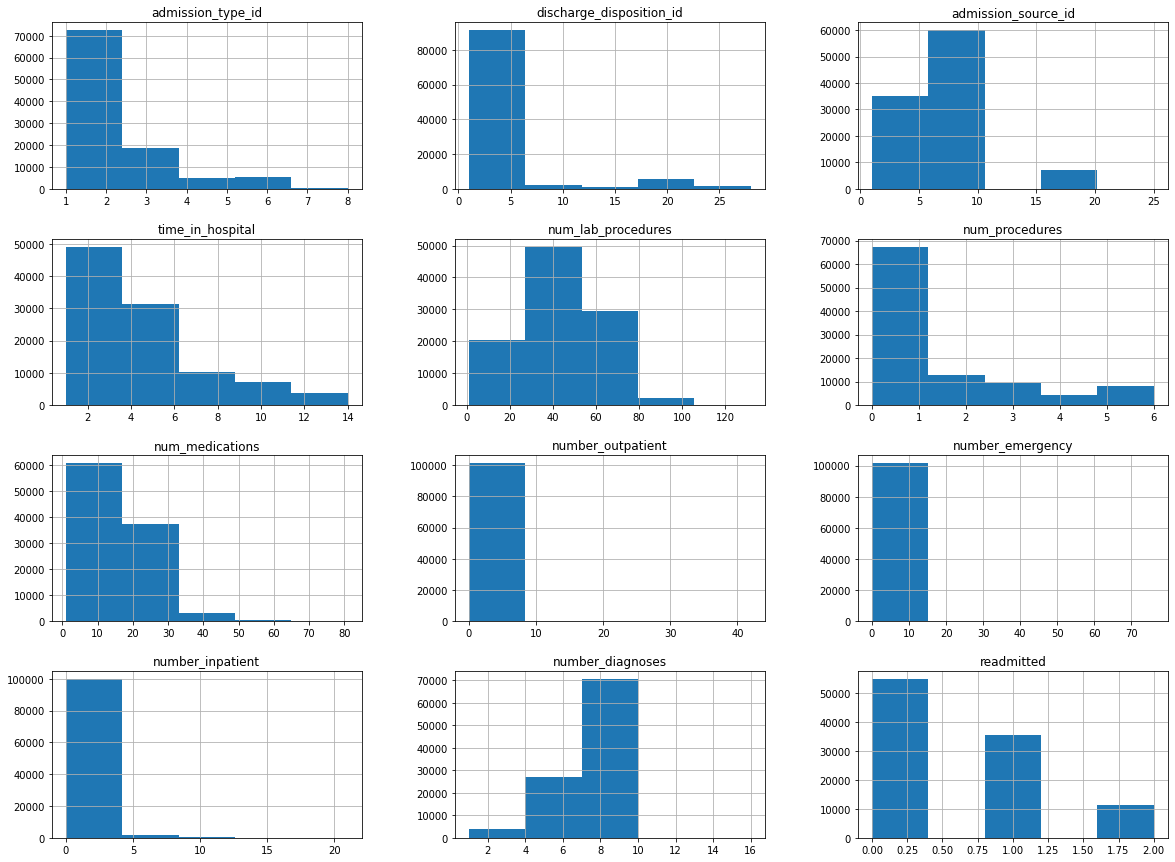

In [10]:
diabetes_df.hist(bins=5, figsize=(20,15))
# plt.savefig('distribution.png')
plt.show()

## Experiments

On the given data set the following transformations is applied-

a) One Hot Encoding - for all categorical variables

b) Scaling the continuous variables to zero mean and scale to unit variance.

In [11]:
df_x = diabetes_df.drop(['readmitted'], axis=1)
df_y = diabetes_df['readmitted']
y_full = np.array(df_y).astype('int32')
categorical_variables = df_x.select_dtypes(include='object').columns.tolist()
continuous_variables = df_x.select_dtypes(exclude='object').columns.tolist()
ct_ss_ohe = ColumnTransformer(
     [('scaling', StandardScaler(), continuous_variables), 
      ('onehot', OneHotEncoder(sparse=False), categorical_variables)])
x_full = ct_ss_ohe.fit_transform(df_x)
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, stratify=df_y,random_state=0)

In [12]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(76324, 113)
(76324,)
(25442, 113)
(25442,)


In [13]:
# Class distribution for the training set.
np.bincount(y_train)

array([41148, 26658,  8518])

In [14]:
print(continuous_variables)
print(categorical_variables)

['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


### Training

#### 1. Ensemble Learning (MLP + SVM) - 3 Class

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

"""
    References:
    https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
    https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-vs-f-relu/27599/2
    https://youtu.be/oPhxf2fXHkQ
    https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
    https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
    https://pytorch.org/tutorials/beginner/basics/intro.html
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    https://youtu.be/PXOzkkB5eH0
"""

class DiabetesDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).long()
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer = nn.Linear(113, 25)
        self.output_layer = nn.Linear(25, 3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.hidden_layer(x)
        h_f = self.relu(x)
        x = self.output_layer(h_f)
        return x, h_f

class Model():
    def __init__(self, model, optimizer, loss_function):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
    
    def train(self, train_loader, epochs):
        self.train_loader = train_loader
        for epoch in range(epochs):
            for i, data in enumerate(train_loader):
                inputs = data[0].to(device)
                labels = data[1].to(device)
                self.optimizer.zero_grad()
                outputs, h_f = self.model(inputs)
                loss = self.loss_function(outputs, labels)
                loss.backward()
                self.optimizer.step()

                if (i+1)%100==0:
                    print (f'Epoch: {epoch+1}/{epochs}\t', end='', flush=True)
                    print (f'Batch: {i+1}/{len(train_loader)}\t', end='', flush=True)
                    print (f'Loss: {loss.item()}', flush=True)
            print ('=======================================================================================')
        return

    def test(self, test_loader):
        self.test_loader = test_loader
        probs = np.array([])
        with torch.no_grad():
            correct = 0
            total = 0
            for i, data in enumerate(test_loader):
                inputs = data[0].to(device)
                labels = data[1].to(device)
                outputs, h_f = self.model(inputs)
                if i==0:
                    probs = F.softmax(outputs, dim=1).numpy()
                else:
                    probs = np.vstack( (probs, F.softmax(outputs, dim=1).numpy() ))
                _, batch_pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (batch_pred==labels).sum().item()
        accuracy = (correct/total)*100
        return accuracy, probs
    
    def feature_extractor(self, data_loader):
        extracted_data = np.array([])
        with torch.no_grad():
            
            for i, data in enumerate(data_loader):
                inputs = data[0].to(device)
                labels = data[1].to(device)
                outputs, h_f = self.model(inputs)
                if i==0:
                    extracted_data = np.column_stack((h_f.numpy(), labels.numpy()))
                else:
                    extracted_data = np.vstack( (extracted_data, np.column_stack( ( h_f.numpy(), labels.numpy() ) ) ))
        return extracted_data

batch_size = 256
lr = 0.001
epochs=400

"""
    References:
    https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
    https://pytorch.org/docs/stable/data.html
"""
train_data = DiabetesDataset(x_train, y_train)
test_data = DiabetesDataset(x_test, y_test)


train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)


net = Net().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_function = torch.nn.CrossEntropyLoss()
model_mlp_3_class = Model(net, optimizer, loss_function)

model_mlp_3_class.train(train_loader=train_loader, epochs=epochs)

Epoch: 1/400	Batch: 100/299	Loss: 0.9016538858413696
Epoch: 1/400	Batch: 200/299	Loss: 0.9707433581352234
Epoch: 2/400	Batch: 100/299	Loss: 0.9246639013290405
Epoch: 2/400	Batch: 200/299	Loss: 0.9259165525436401
Epoch: 3/400	Batch: 100/299	Loss: 0.9675092101097107
Epoch: 3/400	Batch: 200/299	Loss: 0.8704255819320679
Epoch: 4/400	Batch: 100/299	Loss: 0.8839669823646545
Epoch: 4/400	Batch: 200/299	Loss: 0.8828101754188538
Epoch: 5/400	Batch: 100/299	Loss: 0.9442939162254333
Epoch: 5/400	Batch: 200/299	Loss: 0.8254714608192444
Epoch: 6/400	Batch: 100/299	Loss: 0.9071173071861267
Epoch: 6/400	Batch: 200/299	Loss: 0.9364822506904602
Epoch: 7/400	Batch: 100/299	Loss: 0.8629741072654724
Epoch: 7/400	Batch: 200/299	Loss: 0.9028062224388123
Epoch: 8/400	Batch: 100/299	Loss: 0.8572478294372559
Epoch: 8/400	Batch: 200/299	Loss: 0.9017153382301331
Epoch: 9/400	Batch: 100/299	Loss: 0.8890824317932129
Epoch: 9/400	Batch: 200/299	Loss: 0.8716899156570435
Epoch: 10/400	Batch: 100/299	Loss: 0.859801590

In [19]:
mlp_3_class_train_accuracy, mlp_3_class_train_prob = model_mlp_3_class.test(train_loader)
print ('Train Accuracy: ', mlp_3_class_train_accuracy)

Train Accuracy:  59.21597400555526


In [32]:
mlp_3_class_test_accuracy, mlp_3_class_test_prob = model_mlp_3_class.test(test_loader)
print ('Test Accuracy: ', mlp_3_class_test_accuracy)

Test Accuracy:  57.93962738778398


In [34]:
extracted_data = model_mlp_3_class.feature_extractor(train_loader)
print (extracted_data.shape)
print (extracted_data)
x_train = extracted_data[:, :-1]
y_train = extracted_data[:, -1]

(76324, 26)
[[1.63461089 0.         2.40203953 ... 0.90112913 0.         0.        ]
 [1.20907962 0.         2.52452278 ... 1.41476011 0.         0.        ]
 [1.61572468 0.16420513 1.6169405  ... 0.21261965 0.         2.        ]
 ...
 [1.44827628 1.66148019 1.76075435 ... 0.02373062 0.         0.        ]
 [1.28873312 0.         1.21162701 ... 0.         0.17329943 1.        ]
 [2.24921131 1.37956941 1.47473288 ... 0.         0.09907541 0.        ]]


In [35]:
extracted_data = model_mlp_3_class.feature_extractor(test_loader)
print (extracted_data.shape)
print (extracted_data)
x_test = extracted_data[:, :-1]
y_test = extracted_data[:, -1]

(25442, 26)
[[1.27307391 0.         3.9164834  ... 0.         0.         0.        ]
 [1.69262528 0.13541126 3.71007013 ... 0.         0.         1.        ]
 [0.7314226  1.37354076 1.49514461 ... 1.47849452 0.         0.        ]
 ...
 [1.84355009 0.06629168 2.98042893 ... 0.         0.3945021  2.        ]
 [1.96599364 0.09985776 1.46174121 ... 0.72413886 0.         0.        ]
 [1.58532965 0.26139972 2.24469256 ... 1.23387575 0.         0.        ]]


In [25]:
from sklearn.svm import SVC
svm = SVC()
svm.C = 1
svm = svm.fit(x_train, y_train)

In [36]:
print (svm.score(x_train, y_train))

0.5915308421990462


In [26]:
print (svm.score(x_test, y_test))

0.5820690197311532
